# Final Project: Wind Integration in ISO New England
**Eliza Cohn and Julia Simpson**

**EEEL 4220 Fall 2023**

<font color='blue'>**Key information in blue**</font>

# Directions

## Introduction
You take the position of a policy maker to provide policy suggestions to decarbonize ISO New England and are given the attached one-bus system model and. Details about this system model are explained in the attached paper. Note the model in this paper has 8 buses with no transmission limits, so it is equivalent to a single-bus model (ISO New England has minor congestion issues).
ISONE expects to install a total wind generation capacity of 12,000 MW by 2030 and would like to study how to best integrate wind generation. You are provided with one week (168 hours) of data including wind generation capacity factors and demand. The wind generator capacity factor is a normalized value between zero to one representation ratio between the actual wind generation and the installed wind capacity over each hour.

## Project Objective

Please finish a report summarizing how to best integrate up to 12,000 MW of wind generation into the system and how the wind generation would impact the system operating cost. You should explore three levels of wind capacity:
- Low: 2,000 MW
- Medium: 6,000 MW • High: 12,000 MW

You need to implement a unit commitment simulation and explore approaches that could improve the wind integration ratio, these approaches include but are not limited to
- Add carbon tax that increases the cost of traditional generators. You can use the EIA website1 to look up emission factors of different fuel types.
- Add tax incentives for wind integration, in this case, you should add a negative cost of wind generation wt to the objective function.
- Retirement of coal power plants.

At each scenario, use the following indexes to compare the system performance
- The total generation cost.
- The wind curtailment ratio - the ratio between the wind that was not integrated into the system
(Wt − wt) to the total wind capacity available (Wt).
- Profits received by generators.
- The average electricity price.
- The profit received by generators.

Finally, your project and report should conclude your recommendation of the best solution that balances electricity cost, system-wide carbon emission, and generator revenue. Note that there will not be a unique solution, and you should use your own judgements about which one you think is the best.

## Directions
1. The major effort in this project is to program a unit commitment model. **Wind generation should be modeled as a zero marginal cost resource (or negative marginal cost if it has tax credits) and can be curtailed**, i.e., wt ≤ WAt, where W are installed wind capacity, At is the time-variant capacity factor given in the data, and wt is the actual wind power integrated into the grid. w should be included in the nodal power balance as a generator. For the rest, please refer to the complete unit commitment formulation in the attachment.
2. You are given a full week’s profile but performing a unit commitment with 168 hours might be overwhelming for your computer. Instead, you should perform sequential daily unit commitments of 24 hours, and pass decision variables as the starting point (in which they become coefficients) for your next unit commitment. These will include gi,t and ui,t. You must also update SUi, and SDi accordingly based on the start-up/down status. For your first operating day, you can assume all generators have been off long enough and set these parameters.
3. The generator cost data includes a quadratic term and a linear term. **You can either use mixed- integer quadratic programming to solve it directly or apply piece-wise linear (five segments per generator max) to the cost curve and convert the problem into MILP.**
4. You can assume all generators are off at the start of each scenario with a zero must-down time, i.e., you can start any generators at the start of the horizon.
5. After implementing a functional unit commitment model, please adjust the installed wind power capacity and other intervention methods, observe the result from each scenario, and summarize the results in your report.

## Appendix - Unit Commitment Formulation

Indexes
- $t$: Time period index $t ∈ {1,2,...,T}$, a total of $T$ time periods. 
- $b$: Bus index $b ∈ {1,2,...,B}$, a total of $B$ buses.
- $i$: Generator index $i ∈ {1,2,...,I}$, a total of $I$ generators.
- $l$: Line index $l ∈ {1,2,...,L}$, a total of $L$ lines.

Cost parameters
- $QC_i$: the quadratic generation cost term for generator $i$.
- $LC_i$: the linear generation cost term for generator $i$.
- $NLC_i$: no load cost for generator $i$.
- $SUC_i$: start-up cost for generator $i$.

Unit constraints parameters
- $Gmax_i$: maximum generation of generator $i$
- $Gmin_i$: minimum generation of generator $i$
- $Tup_i$: minimum up time of generator $i$
- $Tdn_i$: minimum down time of generator $i$
- $RR_i$: ramp rate of generator $i$
- $SU_i$: number of time periods generator $i$ must stay up since the start of the optimization horizon.
- $SD_i$: number of time periods generator $i$ must stay down since the start of the optimization horizon.

Demand and renewable parameters
- $W$: installed wind capacity
- $α_t$: wind capacity factor during time period $t$
- $D_t$: system demand during time period $t$

Continuous decision variables
- $g_{i,t}$: production of generator $i$ during time period $t$
- $r_{i,t}$: hourly reserve generator $i$ could provide during time period $t$
- $w_t$: wind power generation during time period $t$
- $s_t$: slack variable representing cost of load shedding during time period $t$

Binary decision variables
- $u_{i,t}$: 1 if generator $i$ is on during time period $t$, otherwise zero
- $v_{i,t}$: 1 if generator $i$ is turned on at the start of period $t$, otherwise zero 
- $z_{i,t}$: 1 if generator $i$ is turned off at the start of period $t$, otherwise zero

The objective function minimizes total generation costs. Note that the last term is about the slack variable $s_t$ which represents the cost of load shedding which is priced at $9,000\$/MWh$.

$$ min \sum\limits_{t} \sum\limits_{i} (QC_ig_{i,t}^2 +LC_ig_{i,t} + NLC_iu_{i,t} +SUC_iv_{i,t}) + (9000)s_t $$

Generation limit constraint $ (i ∈ {1,2,...,I}, t ∈ {1,2,...,T}) $ 
$$ Gmin_iu_{i,t} \leq g_{i,t} \leq Gmax_iu_{i,t}$$


Generation ramp constraint, the minimum generation limit adds to the ramp-up limit when the generator is turned on or off $(i ∈ {1,2,...,I}, t ∈ {1,2,...,T}) $

$$ −Gmin_iz_{i,t} − RR_i ≤ g_{i,t} − g_{i,t}−1 ≤ RR_i + Gmin_iv_{i,t} $$

Generator start-up and shut-down logic $(i ∈ {1,2,...,I}, t ∈ {1,2,...,T})$
$$ v_{i,t} − z_{i,t} = u_{i,t} − u_{i,t−1} $$
$$ v_{i,t} + z_{i,t} ≤ 1 $$

Generator minimum up time constraint, note the use of the alternative time index τ , and the constraint only accounts for periods beyond the required must on or off time since the start of the optimization horizon $(i ∈ {1,2,...,I})$
<font color='red'>$$ \sum\limits_{τ=max{t−Tup_i+1,1}}^t v_{i,τ} ≤ u_{i,t},t ∈ {SU_i,...,T}$$ 
<font color='red'>$$ \sum\limits_{τ=max{t−Tdn_i+1,1}}^t z_{i,τ} ≤ 1-u_{i,t},t ∈ {SD_i,...,T}$$ 

accompanied by the must-stay on or off constraints, which passes the on/off requirement from the
previous day to the current day
$$ \sum\limits_{t=1}^{SU_i} u_{i,t} = SU_i $$
$$ \sum\limits_{t=1}^{SD_i} u_{i,t} = 0 $$


Power balance, the dual variable λt associated with this constraint is the system price
$$ \sum\limits_{i} g_{i,t} + w_t + s_t = D_t : \lambda_t $$ 


System reserve (3+5 rule: hourly reserve amount must equal to 3% of demand and 5% of integrated wind)
$$ \sum\limits_{i} r_{i,t} \geq (3\%) D_t + (5\%)w_t $$
$$ r_{i,t} \leq  Gmax_iu_{i,t} − g_{i,t} $$
$$ r_{i,t} \leq RR_i $$

Wind generation limit
$$ w_t \leq \alpha_tW $$

## Data Import

In [20]:
import cvxpy as cp
import numpy as np
import gurobipy
import pandas as pd
import matplotlib.pyplot as plt
import time

gen = pd.read_csv('generator_data.csv')
load = pd.read_csv('wind_and_demand.csv')

## Parameter Definition

In [159]:
I = gen.shape[0] # number of generators
T = 24; # number of hours
D = 1  # To Do: starting day

QC      = gen['Dispatch Cost Quadratic\nCoefficient b \n($/MW^2h)'].ravel() # quadratic gen cost 
LC      = gen['Dispatch Cost Linear\nCoefficient a \n($/MWh)'].ravel()  # marginal generator cost
NLC     = gen['NoLoad\nCost ($)'].ravel()  # no load cost
SUC     = gen['StartUp \nCost ($)'].ravel() # start up cost
GMin    = gen['Minimum generation (MW)'].ravel()  # minium generation
GMax    = gen['Capacity \n(MW)'].ravel()  # maximum generation
RR      = gen['Ramp Rate\n(MW/hr)'].ravel()
Tup     = gen['MinUp\nTime (hr)'].ravel()
Tdn     = gen['MinDown \nTime (hr)'].ravel()

report = pd.read_excel('report.xlsx')
report = report.drop('Unnamed: 0', axis=1)

# Day 0 initialization 
if D == 0:
    u0      = np.zeros(I)  
    g0      = np.zeros(I)  
    SU0     = np.zeros(I)
    SD0     = np.zeros(I)
else: 
    g0      = report['Generator Output EOD ' + str(D-1)]
    u0      = report['Committment Status EOD ' + str(D-1)]
    SU0     = report['SU EOD ' + str(D-1)]
    SD0     = report['SD EOD ' + str(D-1)]

SU      = np.zeros(I)  # Defined at end of day and saved 
SD      = np.zeros(I)  # Defined at end of day and saved 
LOAD    = load.Demand[D*T:T*(D+1)] # Indexing based on run day
LOAD    = LOAD.reset_index(drop=True)

In [160]:
W = 2000 #To Do: Vary Wind Capacty[2000, 6000, 12000]
alpha = load.WindCF[D*T:T*(D+1)]
alpha = alpha.reset_index(drop=True)

## Variable Definition

In [161]:
# the first index is generator, the second is period
g = cp.Variable((I,T), nonneg = True)   # generator dispatch
r = cp.Variable((I,T), nonneg = True)   # hourly reserve generator
w = cp.Variable((T), nonneg = True)   # wind power dispatch
s = cp.Variable((T), nonneg = True)   # slack variable for load shedding

u = cp.Variable((I,T), boolean = True)   # commitment status
v = cp.Variable((I,T), boolean = True)   # start-up status
z = cp.Variable((I,T), boolean = True)   # inverse of start-up status

## Defining Objective Function & Constraints

### Objective Function

$$ min \sum\limits_{t} \sum\limits_{i} (QC_ig_{i,t}^2 +LC_ig_{i,t} + NLC_iu_{i,t} +SUC_iv_{i,t}) + (9000)s_t $$

In [162]:
obj = cp.Minimize(sum(sum(QC @ g**2 + LC @ g + NLC @ u + SUC @ v) + 9000*s))

# If having running issues, remove quadratic cost to ensure running correctly 
# obj = cp.Minimize(sum(sum(LC @ g + NLC @ u + SUC @ v) + 9000*s)) 

### Constraints

Power balance, the dual variable $\lambda_t$ associated with this constraint is the system price
$$ (1) \sum\limits_{i} g_{i,t} + w_t + s_t = D_t : \lambda_t $$ 

Generation limit constraint $ (i ∈ {1,2,...,I}, t ∈ {1,2,...,T}) $ 
$$ \text{(2)  } Gmin_iu_{i,t} \leq g_{i,t} \leq Gmax_iu_{i,t}$$

Wind generation limit
$$ \text{(3)  } w_t \leq \alpha_tW $$

Generation ramp constraint, the minimum generation limit adds to the ramp-up limit when the generator is turned on or off $(i ∈ {1,2,...,I}, t ∈ {1,2,...,T}) $

$$ \text{(4)  } −Gmin_iz_{i,t} − RR_i ≤ g_{i,t} − g_{i,t−1} ≤ RR_i + Gmin_iv_{i,t} $$

Generator start-up and shut-down logic $(i ∈ {1,2,...,I}, t ∈ {1,2,...,T})$
$$ \text{(5)  } v_{i,t} − z_{i,t} = u_{i,t} − u_{i,t−1} $$
$$ \text{(6)  } v_{i,t} + z_{i,t} ≤ 1 $$

System reserve (3+5 rule: hourly reserve amount must equal to 3% of demand and 5% of integrated wind)
$$ \text{(7)  } \sum\limits_{i} r_{i,t} \geq (3\%) D_t + (5\%)w_t $$
$$ \text{(8)  } r_{i,t} \leq  Gmax_iu_{i,t} − g_{i,t} $$
$$ \text{(9)  } r_{i,t} \leq RR_i $$

In [163]:
con_set = [] 

for t in range(T): 
    con_set.append(LOAD[t] == sum(g[:, t])+ w[t] + s[t])    # (1) Demand balance constraint 
    con_set.append( w[t] <= alpha[t]*W )                    # (3) Available wind
    con_set.append(sum(r[:,t]) >= 0.03*LOAD[t] + 0.05*w[t])   # (7) Reserve capacity 
    
    for i in range(I): # go through each generator
        con_set.append(g[i][t] <= GMax[i] * u[i][t])  # (2) Maximum generation limits
        con_set.append(g[i][t] >= GMin[i] * u[i][t])  # (2) Minimum generation limits
        
        con_set.append(v[i][t] + z[i][t] <= 1)        # (6) Start-up and shut-down logic
        
        con_set.append(r[i][t] <= GMax[i]*u[i][t] - g[i][t])   # (8) Available reserve 
        con_set.append(r[i][t] <= RR[i])                       # (9) Available reserve ramp rate

        if t==0: 
            con_set.append(v[i][0] - z[i][0] == u[i][0] - u0[i])          # (5) Generator startup-shutdown logic
            con_set.append(g[i][0] - g0[i] <= RR[i] + GMin[i] * v[i][0])  # (4) Assume g0 = g[i][-1] state from previous day 
            con_set.append(g[i][0] - g0[i] >= -GMin[i] * z[i][0] - RR[i]) # (4) Assume g0 = g[i][-1] state from previous day turned on or off
        else:
            con_set.append(v[i][t] - z[i][t] == u[i][t] - u[i][t-1])          # (5) Generator startup-shutdown logic
            con_set.append(g[i][t] - g[i][t-1] <= RR[i] + GMin[i] * v[i][t])  # (4) Max gen limit added to ramp limit when generator turned on or off
            con_set.append(g[i][t] - g[i][t-1] >= -GMin[i] * z[i][t] - RR[i]) # (4) Max gen limit added to ramp limit when generator turned on or off

#### Min Up/Down Time

Generator minimum up time constraint, note the use of the alternative time index τ , and the constraint only accounts for periods beyond the required must on or off time since the start of the optimization horizon $(i ∈ {1,2,...,I})$
$$ \sum\limits_{\tau=max{t−Tup_i+1,1}}^t v_{i,τ} ≤ u_{i,t},t ∈ {SU_i,...,T}$$ 
$$ \sum\limits_{\tau=max{t−Tdn_i+1,1}}^t z_{i,τ} ≤ 1-u_{i,t},t ∈ {SD_i,...,T}$$ 

In [164]:
for t in range(T):
    for i in range(I):
        if t >= SU0[i]:
            tau = max(t-Tup[i]+1,1)
            con_set.append(sum(v[i][tau:t]) <= u[i][t])

        if t >= SD0[i]:
            tau = max(t-Tdn[i]+1,1)
            con_set.append(sum(z[i][tau:t]) <= 1 - u[i][t])


$$ \sum\limits_{t=1}^{SU_i} u_{i,t} = SU_i $$
$$ \sum\limits_{t=1}^{SD_i} u_{i,t} = 0 $$

In [165]:
for i in range(I): 
    if SU0[i]: 
        for t in range(int(SU[i])):
            con_set.append(u[i][t] == 1)
    if SD0[i]: 
        sd = int(SD[i])
        if sd > T: # if our remaining SD time is longer than our day horizon. 
            SD[i] = sd - T # save remaining comittment for next day 
            sd = T # stay on for the rest of the day 
        for t in range(sd):
            con_set.append(u[i][t] == 0)

## Solve and Check Results

In [166]:
# Solve the problem
t = time.time()

prob = cp.Problem(obj, con_set)
prob.solve(solver = "GUROBI")
prob.solve();

elapsed = time.time() - t
print(elapsed/60)

3.7024479269981385


In [167]:
prob.status

'optimal'

In [168]:
print("\n Total operating cost: %.1f" % obj.value)


 Total operating cost: 243367054.1


### End of Day Accounting

#### Calculate SU & SD for Next Day

$$ SU_i = max(Tup_i - \sum_{v_i[\tau] = 1}^t u_{i,t},0)$$
$$\text{Let } v_i[\tau] = 1 \text{ be the time of most recent turn on}$$
$$$$
$$ SD_i = max(Tdn_i - \sum_{z_i[\tau] = 1}^t(1 - u_{i,t}),0) $$
$$\text{Let } z_i[\tau] = 1 \text{ be the time of most recent turn off}$$

In [169]:
for i in range(I):
    if np.any(v[i].value): # if it has been turned on 
        turnon_time = np.where(v[i].value)[0][-1] 
        SU[i] = max(Tup[i] - sum(u[i][turnon_time:].value),0) 
    else: 
        SU[i] = 0
        
    if np.any(z[i].value): # if it has been turned off
        turnoff_time = np.where(z[i].value)[0][-1]
        SD[i] = max(Tdn[i] - sum(1 - u[i][turnoff_time:].value),0)
    else:
        SD[i] = 0

#### Save Parameters for Next Day

In [173]:
report_eod = pd.DataFrame({
    'Generator Output EOD ' + str(D): pd.Series(g.value[:,T-1]), # end of day final values
    'Committment Status EOD ' + str(D): pd.Series(u.value[:,T-1]),
    'SU EOD ' + str(D): pd.Series(SU),
    'SD EOD ' + str(D): pd.Series(SD)
})

In [174]:
result = pd.concat([report, report_eod], axis=1)

In [102]:
result.to_excel('report.xlsx')

### Plots

In [66]:
# Return generators that turned on at any time t and their original index
nonzero_gens = [(i, row) for i, row in enumerate(g.value) if np.any(row != 0)]

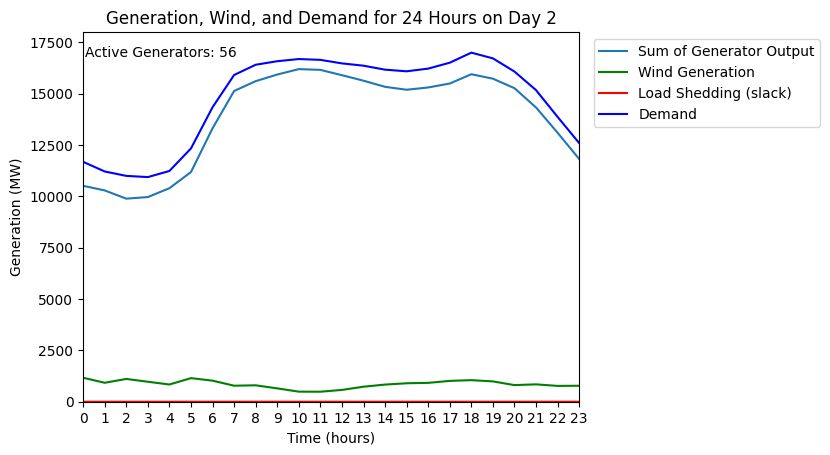

In [179]:
## TOTAL GENERATOR STATUS

# Time axis
x = np.linspace(0, T-1, T) 

plt.plot(x, sum(g.value[:]), label = 'Sum of Generator Output')
plt.plot(x, w.value, label='Wind Generation', color='g')
plt.plot(x, s.value, label='Load Shedding (slack)', color='r')
plt.plot(x, LOAD, label='Demand', color='b')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(x)  # Only integer x ticks
plt.ylim(0, max(LOAD)+1000)
plt.xlabel('Time (hours)')
plt.ylabel('Generation (MW)')
plt.title(f'Generation, Wind, and Demand for {T} Hours on Day {D+1}')
plt.text(0.1, max(LOAD), f'Active Generators: {len(nonzero_gens)}', verticalalignment='center', horizontalalignment='left')

# Adding a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.show()

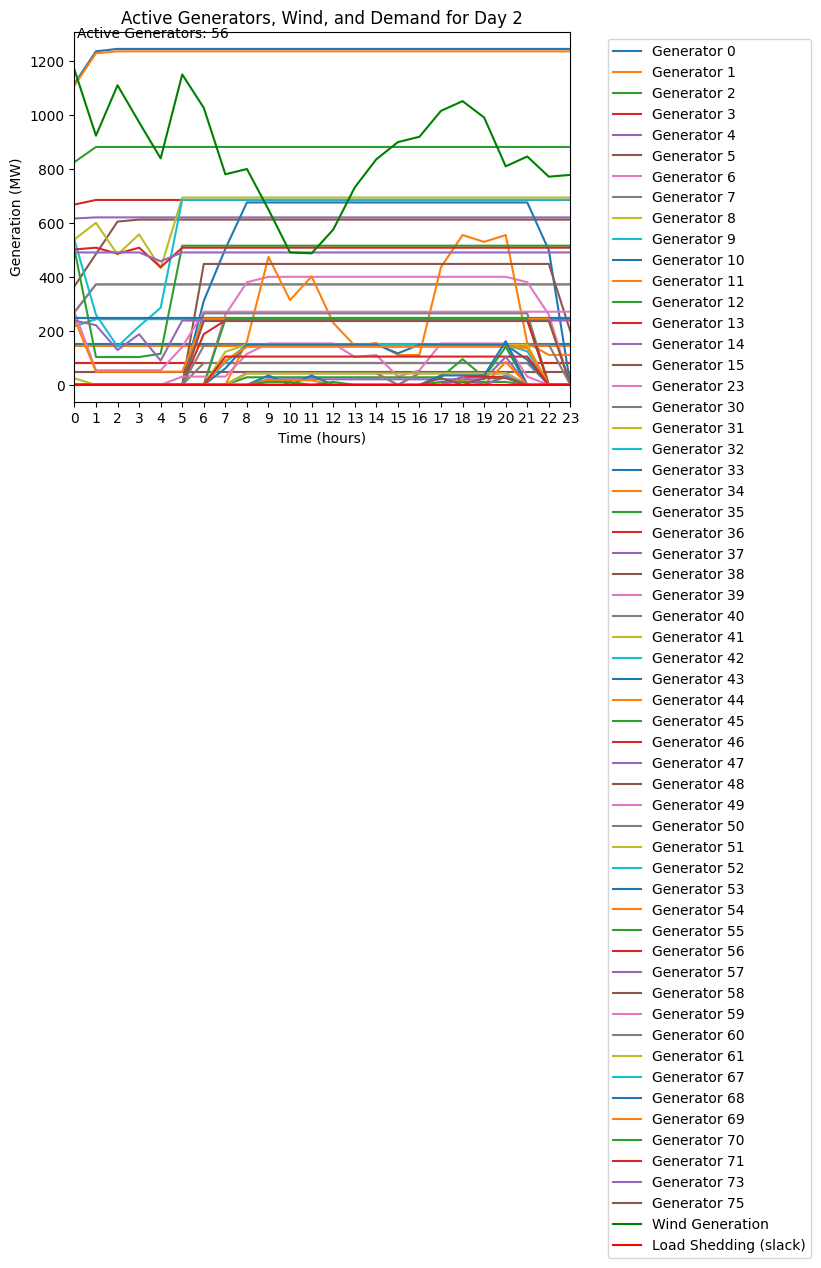

In [171]:
## INDIVIDUAL GENERATOR STATUS

# Time axis
x = np.linspace(0, T-1, T) 

# Plotting the active generators
I_no0 = len(nonzero_gens)
for i in range(I_no0):
    plt.plot(x, nonzero_gens[i][1],label=f'Generator {nonzero_gens[i][0]}')
    
plt.plot(x, w.value, label='Wind Generation', color='g')
plt.plot(x, s.value, label='Load Shedding (slack)', color='r')
# plt.plot(x, LOAD, label='Demand', color='b')

# Adding labels and title
plt.xlim(0,T-1)
plt.xticks(x)  # Only integer x ticks
#plt.ylim(0, max(LOAD)+1000)
plt.xlabel('Time (hours)')
plt.ylabel('Generation (MW)')
plt.title(f'Active Generators, Wind, and Demand for Day {D+1}')
plt.text(0.1, 1300, f'Active Generators: {len(nonzero_gens)}', verticalalignment='center', horizontalalignment='left')

# Adding a legend
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))

# Display the plot
plt.show()

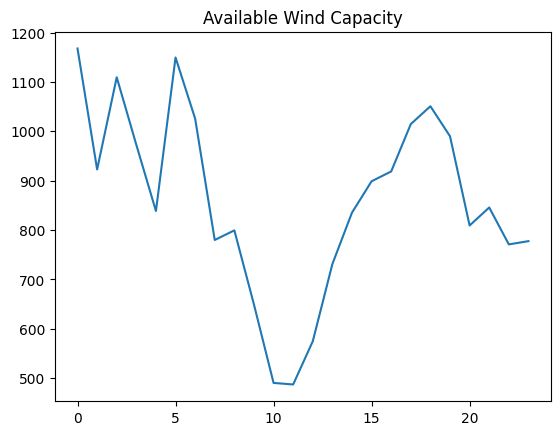

In [172]:
# Plot Wind Capacity
plt.plot(alpha[:T]*W)
plt.title('Available Wind Capacity')
plt.show()

## APPENDIX